<a href="https://colab.research.google.com/github/phoumithona/machine_learning_deep_learning/blob/master/GAN_Image_Completion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0],28,28,1)
train_images = (train_images-127.5)/127.5

BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Discriminator Model


In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(7,(3,3),padding="same",input_shape=(28,28,1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(50,activation="relu"))
    model.add(tf.keras.layers.Dense(1))
    return model

model_discriminator = make_discriminator_model()
model_discriminator(np.random.rand(1,28,28,1).astype("float32"))

discriminator_optimizer = tf.optimizers.Adam(1e-3)

def get_discriminator_loss(real_predictions, fake_predictions):
    real_predictions = tf.sigmoid(real_predictions)
    fake_predictions = tf.sigmoid(fake_predictions)
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions)
    return fake_loss+real_loss

## Generator

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, input_shape = (100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape((7,7,256)))
    model.add(tf.keras.layers.Conv2DTranspose(128,(3,3),padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1,(3,3),strides=(2,2),padding="same"))
    return model

generator = make_generator_model()
generator_optimizer = tf.optimizers.Adam(1e-4) 

def get_generator_loss(fake_predictions):
    fake_predictions = tf.sigmoid(fake_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions),fake_predictions)
    return fake_loss

## Training

In [10]:
def train(dataset, epochs):
    for _ in range(epochs):
        for images in dataset:
            images = tf.cast(images, tf.dtypes.float32)
            train_step(images)

def train_step(images):
    fake_image_noise = np.random.randn(BATCH_SIZE, 100).astype("float32")
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(fake_image_noise)
        real_output = model_discriminator(images)
        fake_output = model_discriminator(generated_images)
        
        gen_loss = get_generator_loss(fake_output)
        disc_loss = get_discriminator_loss(real_output, fake_output)
        
        gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradient_of_discriminator = disc_tape.gradient(disc_loss, model_discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, model_discriminator.trainable_variables))
        
        print("generator loss: ", np.mean(gen_loss))
        print("discriminator loss: ", np.mean(disc_loss))

In [11]:
train(train_dataset, 20)

Streaming output truncated to the last 5000 lines.
discriminator loss:  0.0020978535
generator loss:  10.271977
discriminator loss:  0.0011562901
generator loss:  10.971563
discriminator loss:  0.0023657316
generator loss:  11.991856
discriminator loss:  0.008627692
generator loss:  12.693843
discriminator loss:  0.0042983913
generator loss:  12.487748
discriminator loss:  0.0015270355
generator loss:  12.135594
discriminator loss:  0.006092883
generator loss:  12.108904
discriminator loss:  0.00017110597
generator loss:  11.257423
discriminator loss:  0.0008111283
generator loss:  10.938181
discriminator loss:  0.0019409738
generator loss:  10.266945
discriminator loss:  0.003805955
generator loss:  10.255316
discriminator loss:  0.010580981
generator loss:  10.149398
discriminator loss:  0.0064810584
generator loss:  10.784647
discriminator loss:  0.027211707
generator loss:  10.842443
discriminator loss:  0.021938687
generator loss:  9.788144
discriminator loss:  0.018513495
generat

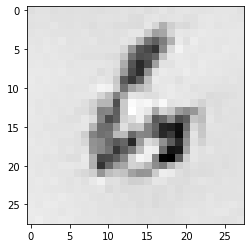

In [17]:
plt.imshow(tf.reshape(generator(np.random.randn(1, 100)), (28,28)), cmap="Greys")